In [1]:
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from collections import Counter

from google.colab import drive
from datetime import datetime

In [2]:
drive.mount('/content/drive')
root_path = 'drive/My Drive/KU/Robin_lab_project' 
os.chdir(root_path)

Mounted at /content/drive


In [4]:
# Set details for saving the plots
DIRECTORY = "Plots/new_implementation_1x_data/"
FILENAME = "rank_negFiltered_atleast2max_negRatio_1_v2"

# Data exploration

In [ ]:
# Load data 
profiles_all = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}.csv")
metadata_all = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}.csv")

X = profiles_all.drop("label", axis=1)
X = StandardScaler().fit_transform(X)
y = profiles_all["label"]

print(X.shape)
print(y.shape)

### PCA


In [ ]:
#  PCA plot
def multi_plot_pca(x, y, 
                   nrows=2, xlim=(-23,43), ylim=(-23,23),
                   figsize=(12,7), top=0.89,
                   title="", save=False, filename="pca_multiplot"):
  # Perform PCA and MDS
  n_pcs = nrows*3+1
  pca = PCA(n_components=n_pcs)
  pcs = pca.fit_transform(x)
  var = pca.explained_variance_ratio_ * 100
  tmp_df = pd.concat([pd.DataFrame(pcs), y], axis = 1)
  targets = [1,0]
  colors = ["r","g"]
  # Plot fig and axes
  fig, axes = plt.subplots(nrows, 3, figsize = figsize, sharex=True, sharey=True)
  fig.add_subplot(111, frameon=False)
  for target, color in zip(targets,colors):
    i_keep = tmp_df['label'] == target
    for i ,ax in enumerate(axes.flatten()):
      ax.scatter(tmp_df.loc[i_keep,i], tmp_df.loc[i_keep,i+1], zorder=3, 
                      ec="black", c=color, s=25, alpha = 0.8, label = target) 
      ax.set_title(f"PC{i+1} ({var[i]:.2}%) and PC{i+2} ({var[i+1]:.2}%)")
      ax.set_xlim(xlim)
      ax.set_ylim(ylim)
  # Details
  legend = ax.legend(title="Labels", fontsize=13, title_fontsize=13,
                     frameon = 1, shadow = True, bbox_to_anchor=(1.3, 1.25))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
  fig.suptitle(f"PCA first {n_pcs} PCs{title}", fontsize=16)
  plt.xlabel("First (relative) component", fontsize=13)
  plt.ylabel("Second (relative) component", fontsize=13)
  fig.tight_layout()
  fig.subplots_adjust(top=top)
  if save == True:
      plt.savefig(f"{DIRECTORY}{filename}_{FILENAME}.png", dpi = 300)
  plt.show()

multi_plot_pca(X, y, nrows=3, xlim=(-43,63), ylim=(-53,54),
               figsize=(14,11), top=0.9, save=True)     

### Correlation

In [ ]:
# Correlation
X = pd.DataFrame(X, columns = list(profiles_all.drop("label", axis=1).columns))
correlation = X.corr(method='pearson')

# Plot
fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(correlation, mask = np.zeros_like(correlation, dtype = np.bool), cmap = "seismic",
            square=True, ax=ax, vmin=-1, vmax=1)
plt.title("Correlation Plot", fontsize=15)
plt.xticks(rotation=45, ha='right', fontsize=6)
plt.yticks(fontsize=7)
plt.savefig(f"{DIRECTORY}correlation_plot_{FILENAME}.png", dpi = 300)
plt.show()

# Models development

### Split train and test by chromosomes number

In [12]:
# Load data divded by chr number
profiles_train = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}_train.csv")
#profiles_test = pd.read_csv(f"Data/ML_input/profiles_{FILENAME}_test.csv")
metadata_train = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}_train.csv")
#metadata_test = pd.read_csv(f"Data/ML_input/metadata_{FILENAME}_test.csv")

# Divide predictor and target
X_TRAIN = profiles_train.drop("label", axis = 1)
y_TRAIN = profiles_train["label"]
#X_TEST = profiles_test.drop("label", axis = 1)
#y_TEST = profiles_test["label"]

# # Normalization
# scaler = StandardScaler()
# X_TRAIN = scaler.fit_transform(X_TRAIN)
# X_TEST = scaler.transform(X_TEST)

print(X_TRAIN.shape)
print(y_TRAIN.shape)
#print(X_TEST.shape)
#print(y_TEST.shape)

(99379, 1002)
(99379,)


Some useful functions

In [13]:
def get_accuracy(ypred, y):
  return sum(ypred == y) / len(y)

def get_rmse(yprob, y):
  return np.sqrt(np.mean((yprob-y)**2))

def print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name):
  print(f"Train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
  print(f"Train F1-score: {f1_score(ytrain, ytrain_pred):.4}")  
  print(f"Train MCC: {matthews_corrcoef(ytrain, ytrain_pred):.4}")
  print(f"Test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
  print(f"Test F1-score: {f1_score(ytest, ytest_pred):.4}")
  print(f"Test MCC: {matthews_corrcoef(ytest, ytest_pred):.4}")

  cf_matrix = confusion_matrix(ytest, ytest_pred)
  group_counts = [f"{value}" for value in cf_matrix.flatten()]
  row_sums = cf_matrix.sum(axis=1)
  norm_matrix = cf_matrix / row_sums[:, np.newaxis]
  group_percentages = [f"{value*100:.2f}%" for value in norm_matrix.flatten()]
  print(f"Test TNR = {group_percentages[0]}")
  print(f"Test TPR = {group_percentages[3]}")

def print_output_eval(train_output, val_output, name):
  train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
  val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
  train_f1 = f1_score(train_output["ytrue"].values, train_output["ypred"].values)
  val_f1 = f1_score(val_output["ytrue"].values, val_output["ypred"].values)
  train_mcc = matthews_corrcoef(train_output["ytrue"].values, train_output["ypred"].values)
  val_mcc = matthews_corrcoef(val_output["ytrue"].values, val_output["ypred"].values)
  print(f"\n>> {name} final report")
  print(f"Train CV accuracy: {train_acc:.4}")
  print(f"Train CV F1-score: {train_f1:.4}")
  print(f"Train MCC: {train_mcc:.4}")
  print(f"Valid CV accuracy: {val_acc:.4}")
  print(f"Valid CV F1-score: {val_f1:.4}")
  print(f"Valid CV MCC: {val_mcc:.4}")

  cf_matrix = confusion_matrix(val_output["ytrue"], val_output["ypred"], labels=[0,1])
  group_counts = [f"{value}" for value in cf_matrix.flatten()]
  row_sums = cf_matrix.sum(axis=1)
  norm_matrix = cf_matrix / row_sums[:, np.newaxis]
  group_percentages = [f"{value*100:.2f}%" for value in norm_matrix.flatten()]
  print(f"Valid TNR = {group_percentages[0]}")
  print(f"Valid TPR = {group_percentages[3]}")

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


Randomly split TRAIN into train and validation keeping labels proportion (used as faster validation in alternative to CV)

In [14]:
# # Split training set into train and validation
# sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=20)
# sss.split(X_TRAIN, y_TRAIN)

# for itrain, ival in sss.split(X_TRAIN, y_TRAIN):
#   X_train, X_val = X_TRAIN.iloc[itrain], X_TRAIN.iloc[ival]
#   y_train, y_val = y_TRAIN[itrain], y_TRAIN[ival]

# # Normalization
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.transform(X_val)

# print(X_train.shape)
# print(y_train.shape)
# print(X_val.shape)
# print(y_val.shape)

Subset the data for fast testing

In [15]:
# # Use reduced size for fast testing
# metadata_train = metadata_train[:5000]
# X_TRAIN, y_TRAIN = X_TRAIN[:5000], y_TRAIN[:5000]
# X_train, y_train = X_train[:5000], y_train[:5000]
# X_val, y_val = X_val[:3000], y_val[:3000] 

# print(metadata_train.shape)
# print(X_TRAIN.shape, y_TRAIN.shape)
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

In [16]:
# # Further reduce the size
# metadata_train = metadata_train[:300]
# X_TRAIN, y_TRAIN = X_TRAIN[:300], y_TRAIN[:300]
# X_train, y_train = X_train[:200], y_train[:200]
# X_val, y_val = X_val[:100], y_val[:100] 

# print(metadata_train.shape)
# print(X_TRAIN.shape, y_TRAIN.shape)
# print(X_train.shape, y_train.shape)
# print(X_val.shape, y_val.shape)

## Random forest

### Hyperparameter tuning

In [17]:
# Custom CV split by chromosomes
def cv_split_by_chr(metadata, n_val_chr=6, max_cv_iter="auto", cv_seed=None):
  chr_list = np.unique(metadata.chr)
  random.seed(cv_seed)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  if max_cv_iter != "auto":
    val_chr_folds = val_chr_folds[0:max_cv_iter]
  print("Validation chromosomes:")
  [print(list(x)) for x in val_chr_folds]
  # Generate a list of tuple where each tuple contain two list of indexes (train and val)
  list_fold_index = []
  for val_chr in val_chr_folds:
    ival = metadata.chr.isin(val_chr)
    list_fold_index.append((list(np.where(~ival)[0]), list(np.where(ival)[0])))
  return list_fold_index

# Hyperparameters random or grid search
def par_search(model, param_grid,
               xtrain, ytrain, metadata, 
               search="random", n_iter=24, n_val_chr=6, max_cv_iter="auto", 
               cv_seed=None, verbose=10):
  if search == "random":
    print(f"Hyperparameters search = {search}\n")
    model_search = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = n_iter, 
                                      return_train_score = True, 
                                      cv = cv_split_by_chr(metadata, n_val_chr=n_val_chr, 
                                                           max_cv_iter=max_cv_iter, cv_seed=cv_seed), 
                                      scoring = make_scorer(f1_score, average = "macro"), verbose=verbose)
  elif search == "grid":
    print(f"Hyperparameters search = {search}\n")
    model_search = GridSearchCV(estimator = model, param_grid = param_grid, return_train_score = True,
                                cv = cv_split_by_chr(metadata, n_val_chr=n_val_chr, 
                                                     max_cv_iter=max_cv_iter, cv_seed=cv_seed), 
                                scoring = make_scorer(f1_score, average = "macro"), verbose=verbose)
  try:
    print("\nParameter grid:")
    display(param_grid)
    print("")
    model_search.fit(xtrain, ytrain)
    return model_search
  except:
    print("Search argument must be \"random\" or \"grid\"")

Comment out the following for parameter tuning

In [18]:
# # # Perform search
# # bootstrap = [True, False]
# # criterion = ['gini']
# # n_estimators = [10, 20, 100, 500, 1000]
# # max_features = ["auto"]
# # max_depth = [104, None]
# # min_samples_split = [2, 5, 10, 0.1]
# # min_samples_leaf = [1, 2, 4, 0.1]
# # max_leaf_nodes = [None]

# # param_grid = { 
# #     "bootstrap": bootstrap,
# #     "criterion" : criterion,
# #     "n_estimators": n_estimators,
# #     "max_features": max_features,
# #     "max_depth" : max_depth,
# #     "min_samples_split": min_samples_split,
# #     "min_samples_leaf": min_samples_leaf,
# #     "max_leaf_nodes": max_leaf_nodes
# # }

# # Suggested by Marco

# param_grid = {'bootstrap': [True, False],
#               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#               'max_features': ['auto', 'sqrt'],
#               'min_samples_leaf': [1, 2, 5, 10, 20],
#               'min_samples_split': [2, 5, 10, 20],
#               'n_estimators': [100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# rf_clf = RandomForestClassifier(n_jobs=-1, class_weight = "balanced_subsample")

# rf_search_output = par_search(rf_clf, param_grid,
#                               X_TRAIN, y_TRAIN, metadata_train, 
#                               search="random", n_iter=150, 
#                               n_val_chr=10, max_cv_iter="auto", 
#                               cv_seed=33, verbose=5)

# # Potrei usare un subset of 16k samples per velocizzare oppure utilizzare una normale CV per splittare in train and test 
# # (cosi da poter fare due iterazioni ma mantenere 70% test 30% train)

# # Plot parameters
# # Make a function that take a df of predictors and plot each one against a target variable vector
# # Ha senso solo per grid search 
# # Se il parameter è categorical, fai box_plot, se numerical plotta una linea

In [19]:
# def get_search_combination(search_output):
#   result_search = pd.DataFrame(search_output.cv_results_)
#   drop_col1 = ['std_fit_time', 'mean_score_time', 'std_score_time', 'params', 'std_test_score', 'std_train_score']
#   drop_col2 = result_search.columns[result_search.columns.str.startswith('split')]
#   drop_col = drop_col1 + list(drop_col2)
#   result_search = result_search.drop(drop_col, axis = 1).sort_values("rank_test_score")
#   return result_search

# rf_par_combination = get_search_combination(rf_search_output)
# display(rf_par_combination.head(20))

# rf_par_combination.to_csv(f"{DIRECTORY}rf_opt_parameters_{FILENAME}.csv", index=False)

In [20]:
# # Assign optimal parameters
# rf_opt_par = rf_par_combination.iloc[:,rf_par_combination.columns.str.startswith('param')].head(1)
# display(rf_opt_par)

# [param_n_estimators, param_min_samples_split,	param_min_samples_leaf,	
#  param_max_features,	param_max_depth,	param_bootstrap] = list(rf_opt_par.values[0])

### Training and validation

In [21]:
def rf_train_pred(xtrain, ytrain, xtest, ytest, class_weight=None,
                  n_estimators=100, bootstrap=True, criterion="gini", 
                  max_depth=None, max_features="auto", max_leaf_nodes=None,
                  min_samples_leaf=1, min_samples_split=2, 
                  name="RF"):
  start_time = datetime.now()
  # Train
  model = RandomForestClassifier(n_estimators=n_estimators, bootstrap=bootstrap, 
                                 criterion=criterion, max_depth=max_depth, 
                                 max_features=max_features, class_weight=class_weight,
                                 random_state=49)
  model.fit(xtrain, ytrain)
  # Predict
  ytrain_pred = model.predict(xtrain)
  ytrain_prob = model.predict_proba(xtrain)[:,1]
  ytest_pred = model.predict(xtest)
  ytest_prob = model.predict_proba(xtest)[:,1]
  # Evaluate
  print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred,

#rf_model, rf_train_yprob, rf_train_ypred, rf_val_yprob, rf_val_ypred = rf_train_pred(X_train, y_train, X_val, y_val)   

In [22]:
# Random forest CV
def rf_cv(xtrain, ytrain, metadata, n_val_chr=3, cv_seed=None, 
          normalize=False, class_weight=None, name="RF",
          n_estimators=100, bootstrap="True", criterion="gini", 
          max_depth=None, max_features="auto", max_leaf_nodes=None,
          min_samples_leaf=1, min_samples_split=2):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize arrays to store predictions, true values and feat importance
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  importance = pd.DataFrame()
  importance["feature"] = list(xtrain.columns)
  # Compute class weights if requested
  if class_weight == "custom":
    class_weight = get_class_weights(ytrain.values)
  print(f"Class weigths = {class_weight}")  
  # CV by chromosomes
  chr_list = np.unique(metadata.chr)
  random.seed(cv_seed)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  for i, val_chr in enumerate(val_chr_folds):
    print(f"\n> Starting CV iteration {i+1}, valid chrs = {val_chr}")
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = xtrain[~ival], xtrain[ival]
    y_train, y_val = ytrain[~ival], ytrain[ival]
    if normalize:
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_val = scaler.transform(X_val)
    # Train and predict
    [model, train_yprob, train_ypred, 
     val_yprob, val_ypred] = rf_train_pred(X_train, y_train, X_val, y_val, 
                                           n_estimators=n_estimators, 
                                           bootstrap=bootstrap, 
                                           criterion=criterion, 
                                           max_depth=max_depth, 
                                           max_features=max_features, 
                                           max_leaf_nodes=max_leaf_nodes,
                                           min_samples_leaf=min_samples_leaf, 
                                           min_samples_split=min_samples_split,
                                           class_weight=class_weight)
    importance[f"iteration_{i+1}"] = model.feature_importances_
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec, "ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec, "ytrue": val_ytrue_vec})
  importance["average"] = np.mean(importance, 1)
  # Evaluate
  print_output_eval(train_output, val_output, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output, importance

In [23]:
# RF without balancing weights
rf1_train_output, rf1_val_output, _ = rf_cv(X_TRAIN, y_TRAIN, metadata_train, cv_seed=33)

Performing RF CV
Class weigths = None

> Starting CV iteration 1, valid chrs = ['chr13' 'chr12' 'chr10']
Train accuracy: 0.9584
Train F1-score: 0.9571
Train MCC: 0.9194
Test accuracy: 0.7393
Test F1-score: 0.7314
Test MCC: 0.4799
Test TNR = 77.24%
Test TPR = 70.65%
Duration: 0:06:38.310145

> Starting CV iteration 2, valid chrs = ['chr15' 'chr1' 'chr20']
Train accuracy: 0.9586
Train F1-score: 0.9571
Train MCC: 0.9199
Test accuracy: 0.7194
Test F1-score: 0.7203
Test MCC: 0.4402
Test TNR = 74.24%
Test TPR = 69.79%
Duration: 0:06:11.655202

> Starting CV iteration 3, valid chrs = ['chr11' 'chr22' 'chrY']
Train accuracy: 0.957
Train F1-score: 0.9558
Train MCC: 0.9169
Test accuracy: 0.7111
Test F1-score: 0.7106
Test MCC: 0.4229
Test TNR = 69.54%
Test TPR = 72.75%
Duration: 0:07:11.551759

> Starting CV iteration 4, valid chrs = ['chr21' 'chr5' 'chr7']
Train accuracy: 0.9585
Train F1-score: 0.9574
Train MCC: 0.9196
Test accuracy: 0.7475
Test F1-score: 0.7323
Test MCC: 0.4952
Test TNR = 78.74

In [24]:
# # RF balancing weights by internal algorithm
# rf_bal_train_output, rf_bal_val_output, rf_bal_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train, cv_seed=33,
#                                                                   class_weight="balanced", name="RF balanced")

In [25]:
# # RF balancing weights by custom function
# rf_custom_train_output, rf_custom_val_output, rf_custom_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train, cv_seed=33,
#                                                                            class_weight="custom", name="RF custom bal")

In [26]:
# # RF balancing weights by scaling positive weights by 3
# rf_scaled3_train_output, rf_scaled3_val_output, _ = rf_cv(X_TRAIN, y_TRAIN, metadata_train, cv_seed=33, 
#                                                                               class_weight={0: 2.0, 1: 1.0}, name="RF neg weights x2")

Comment out the following for optimized paramters validation

In [27]:
# rf_opt_train_output, rf_opt_val_output, rf_opt_importance = rf_cv(X_TRAIN, y_TRAIN, metadata_train, 
#                                                                   class_weigth="custom",
#                                                                   name="RF tuned balanced",
#                                                                   n_estimators=param_n_estimators, 
#                                                                   bootstrap=param_bootstrap,       
#                                                                   max_depth=param_max_depth, 
#                                                                   max_features=param_max_features,
#                                                                   min_samples_leaf=param_min_samples_leaf,
#                                                                   min_samples_split=param_min_samples_split)

## LightGBM    

In [28]:
# Scoring functions
def lgb_mcc_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'MCC', matthews_corrcoef(y_true, y_pred), is_higher_better

def lgb_f1_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'F1', f1_score(y_true, y_pred, average='macro'), is_higher_better

def tnr_tpr_score(y_true, y_pred):
    cf_matrix = confusion_matrix(y_true, y_pred)
    group_counts = [f"{value}" for value in cf_matrix.flatten()]
    row_sums = cf_matrix.sum(axis=1)
    norm_matrix = cf_matrix / row_sums[:, np.newaxis]
    return norm_matrix.flatten()[0], norm_matrix.flatten()[3]

def lgb_tnr_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'TNR', tnr_tpr_score(y_true, y_pred)[0], is_higher_better

def lgb_tpr_score(y_pred, y_true):
    y_true = y_true.get_label()
    y_pred = np.round(y_pred)
    is_higher_better = True
    return 'TPR', tnr_tpr_score(y_true, y_pred)[1], is_higher_better
    
# Plot metrics during training
def plot_eval_result(evals_result, best_iteration, num_iterations):
  plt.figure(figsize=(12, 8))
  gs = gridspec.GridSpec(2, 2)
  subplot_indexes = (0,0), (0,1), (1,0), (1,1)
  names = list(evals_result["val"].keys())
  for i, indexes in enumerate(subplot_indexes):
    if i < 3:
      # Plot all metrics except TNR and TPR
      ax = plt.subplot(gs[indexes])
      lgb.plot_metric(evals_result, metric=names[i], ax=ax)  
      ax.set_title(names[i].replace("_", " "), fontsize = 12)  
    else:
      # Plot TNR and TPR
      ax = plt.subplot(gs[1, 1])
      ax.plot(evals_result["val"]["TNR"], label="Val TNR", color="tab:orange")
      ax.plot(evals_result["val"]["TPR"], label="Val TPR", color="tab:red")
      ax.plot(evals_result["train"]["TNR"], label="Train TNR", color="tab:cyan")
      ax.plot(evals_result["train"]["TPR"], label="Train TPR", color="tab:blue")
      plt.grid(zorder=0) 
      ax.set_title("TNR and TPR", fontsize = 12)
      ax.set_ylabel("TR", fontsize = 10)
      ax.set_xlabel("Iterations", fontsize = 10)
    # Add early stopping iteration and legend
    if num_iterations > best_iteration and best_iteration != 0:
      ax.vlines(best_iteration, ymin=-1, ymax=1, color="r", linestyles="dashed", linewidth=0.8, label="best_iter") 
    legend = ax.legend(frameon = 1, shadow = True)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('black') 
  plt.tight_layout()
  plt.show()

# LGBM
def lgb_train_pred(xtrain, ytrain, xtest, ytest, par, 
                   num_iterations=1500, early_stopping_rounds=None, name="LGBM"):
  start_time = datetime.now()
  # Train
  train_data = lgb.Dataset(xtrain , label = ytrain)
  valid_data = lgb.Dataset(xtest, label = ytest)
  evals_result = {}
  model = lgb.train(par, train_data, valid_sets=[train_data, valid_data], valid_names=["train", "val"], 
                    feval = lambda y_pred, y_true: [lgb_mcc_score(y_pred, y_true), lgb_f1_score(y_pred, y_true),
                                                    lgb_tnr_score(y_pred, y_true), lgb_tpr_score(y_pred, y_true)], 
                    verbose_eval=50, evals_result=evals_result, num_boost_round=num_iterations, 
                    early_stopping_rounds=early_stopping_rounds)
  # Predict
  ytrain_prob = model.predict(np.array(xtrain))
  ytrain_pred = np.round(ytrain_prob)
  ytest_prob = model.predict(np.array(xtest))
  ytest_pred = np.round(ytest_prob)
  # Evaluate
  print("")
  print_eval(ytrain, ytrain_pred, ytrain_prob, ytest, ytest_pred, ytest_prob, name)
  plot_eval_result(evals_result, model.best_iteration, num_iterations)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

In [29]:
# params = {"application" : "binary",
#           "metric" :"binary_logloss",
#           "scale_pos_weight": 3
# }
# lgb_model, lgb_train_yprob, lgb_train_ypred, lgb_val_yprob, lgb_val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, params)

In [30]:
# params = {"application" : "binary",
#           "metric": "binary_logloss",
#           "num_boost_round" : 400,
#           "force_row_wise" : True,
#           "learning_rate" : 0.009,            
#           "first_metric_only":True,
#           "scale_pos_weight": 3
# }
# lgb_model, lgb_train_yprob, lgb_train_ypred, lgb_val_yprob, lgb_val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, params)

In [31]:
# LGBM CV
def lgb_cv(xtrain, ytrain, metadata, par, 
           num_iterations=1500, early_stopping_rounds=None,
           n_val_chr=3, cv_seed=None, normalize=True, 
           class_weigth=None, name="LGBM"):
  start_time = datetime.now()
  print(f"Performing {name} CV")
  # Initialize 1d df to store predictions and true values
  train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
  val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
  importance = pd.DataFrame()
  importance["feature"] = list(xtrain.columns)
  # Set class weigth
  if class_weigth == "custom":  
    class_weigth = get_class_weights(ytrain.values)
    pos_weight = round(class_weigth[1] / class_weigth[0], 2)
    par["scale_pos_weight"] = pos_weight
  elif class_weigth == "balanced":
    par["is_unbalance "] = True
  print("\nParameters:")
  print(f"  num_iterations = {num_iterations}")
  print(f"  early_stopping_rounds = {early_stopping_rounds}")
  [print(f"  {x} = {par[x]}") for x in par]
  # CV by chromosomes
  chr_list = np.unique(metadata.chr)
  random.seed(cv_seed)
  random.shuffle(chr_list)
  k = len(chr_list) // n_val_chr
  val_chr_folds = np.array_split(chr_list, k)
  for i, val_chr in enumerate(val_chr_folds):
    print(f"\n> Starting CV iteration {i+1}, valid chrs = {val_chr}")
    ival = metadata.chr.isin(val_chr)
    X_train, X_val = xtrain[~ival], xtrain[ival]
    y_train, y_val = ytrain[~ival], ytrain[ival]
    # Normalization
    if normalize:
      scaler = StandardScaler()
      X_train = scaler.fit_transform(X_train)
      X_val = scaler.transform(X_val)
    # Train and predict
    model, train_yprob, train_ypred, val_yprob, val_ypred = lgb_train_pred(X_train, y_train, X_val, y_val, par=par,
                                                                           num_iterations=num_iterations,
                                                                           early_stopping_rounds=early_stopping_rounds)
    importance[f"iteration_{i+1}"] = model.feature_importance(importance_type='gain')
    # Store prediction on training data
    train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
    train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
    train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
    # Store prediction on validation data
    val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
    val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
    val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
  # Stack training and validation predictions into two panda df
  train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
  val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
  importance["average"] = np.mean(importance, 1)
  # Evaluate
  print_output_eval(train_output, val_output, name)
  # Report time 
  print(f"Duration: {datetime.now() - start_time}")
  return train_output, val_output, importance

# Fixed parameters
learning_rate = 0.009

Performing LGBM CV

Parameters:
  num_iterations = 1500
  early_stopping_rounds = None
  application = binary
  metric = binary_logloss
  force_row_wise = True
  learning_rate = 0.009

> Starting CV iteration 1, valid chrs = ['chr13' 'chr12' 'chr10']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.627324	train's MCC: 0.478923	train's F1: 0.726534	train's TNR: 0.86007	train's TPR: 0.603285	val's binary_logloss: 0.629562	val's MCC: 0.475195	val's F1: 0.720235	val's TNR: 0.876313	val's TPR: 0.577494
[100]	train's binary_logloss: 0.589014	train's MCC: 0.487468	train's F1: 0.729958	train's TNR: 0.867468	train's TPR: 0.603192	val's binary_logloss: 0.59216	val's MCC: 0.482425	val's F1: 0.722077	val's TNR: 0.885558	val's TPR: 0.573054
[150]	train's binary_logloss: 0.564999	train's MCC: 0.491717	train's F1: 0.731681	train's TNR: 0.871001	train's TPR: 0.603308	val's binary_logloss: 0.568595	val's MCC: 0.487994	val's F1: 0.724574	val's TNR: 0.88892	val's TPR: 0.574719
[200]	train's binary_logloss: 0.54917	train's MCC: 0.494143	train's F1: 0.732703	train's TNR: 0.872851	train's TPR: 0.603588	val's binary_logloss: 0.553403	val's MCC: 0.489338	val's F1: 0.724779	val's TNR: 0.891021	val's TPR: 0.573331
[250]	train's binary_logloss: 0.538176	train's MCC: 0.495767	

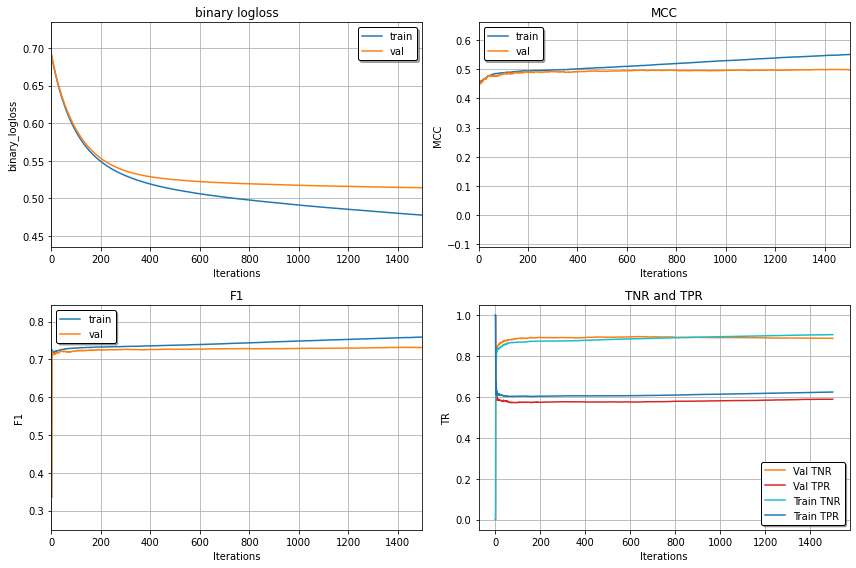

Duration: 0:34:28.578167

> Starting CV iteration 2, valid chrs = ['chr15' 'chr1' 'chr20']
[50]	train's binary_logloss: 0.625925	train's MCC: 0.484306	train's F1: 0.728161	train's TNR: 0.868132	train's TPR: 0.598284	val's binary_logloss: 0.632048	val's MCC: 0.444971	val's F1: 0.705017	val's TNR: 0.857797	val's TPR: 0.570686
[100]	train's binary_logloss: 0.586672	train's MCC: 0.493634	train's F1: 0.732125	train's TNR: 0.875046	train's TPR: 0.59957	val's binary_logloss: 0.597025	val's MCC: 0.454198	val's F1: 0.709095	val's TNR: 0.863936	val's TPR: 0.572973
[150]	train's binary_logloss: 0.562075	train's MCC: 0.498973	train's F1: 0.734411	train's TNR: 0.878888	train's TPR: 0.600435	val's binary_logloss: 0.575947	val's MCC: 0.460361	val's F1: 0.71233	val's TNR: 0.866168	val's TPR: 0.576923
[200]	train's binary_logloss: 0.54588	train's MCC: 0.501558	train's F1: 0.735935	train's TNR: 0.879136	train's TPR: 0.603006	val's binary_logloss: 0.562848	val's MCC: 0.461201	val's F1: 0.712855	val's TNR

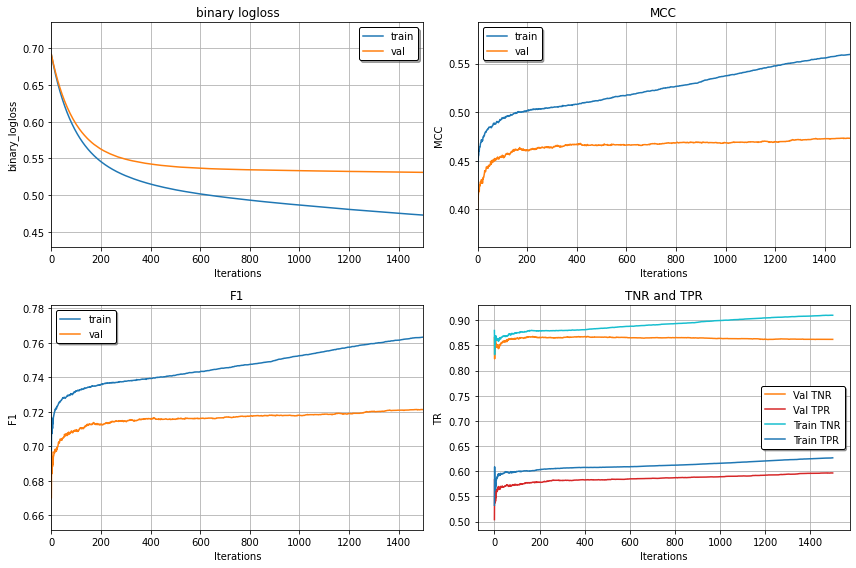

Duration: 0:33:59.420389

> Starting CV iteration 3, valid chrs = ['chr11' 'chr22' 'chrY']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.626589	train's MCC: 0.480011	train's F1: 0.72813	train's TNR: 0.85541	train's TPR: 0.610637	val's binary_logloss: 0.631941	val's MCC: 0.43421	val's F1: 0.710536	val's TNR: 0.813869	val's TPR: 0.610416
[100]	train's binary_logloss: 0.587665	train's MCC: 0.490101	train's F1: 0.731712	train's TNR: 0.86635	train's TPR: 0.607786	val's binary_logloss: 0.597355	val's MCC: 0.447141	val's F1: 0.71632	val's TNR: 0.823867	val's TPR: 0.612204
[150]	train's binary_logloss: 0.563231	train's MCC: 0.497108	train's F1: 0.734222	train's TNR: 0.873568	train's TPR: 0.606185	val's binary_logloss: 0.576907	val's MCC: 0.449088	val's F1: 0.716717	val's TNR: 0.828122	val's TPR: 0.609075
[200]	train's binary_logloss: 0.547168	train's MCC: 0.499815	train's F1: 0.735487	train's TNR: 0.875137	train's TPR: 0.60715	val's binary_logloss: 0.564292	val's MCC: 0.455419	val's F1: 0.720001	val's TNR: 0.830249	val's TPR: 0.613321
[250]	train's binary_logloss: 0.53608	train's MCC: 0.501514	tra

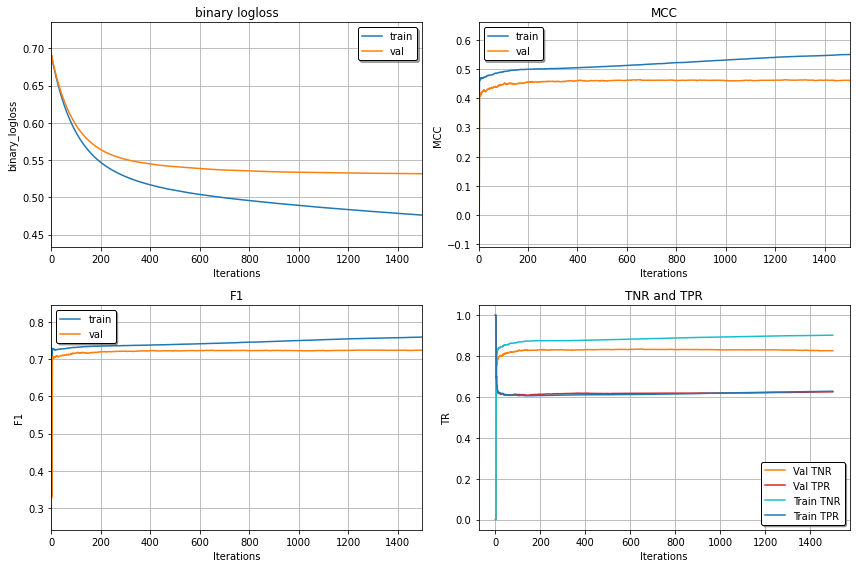

Duration: 0:35:10.196229

> Starting CV iteration 4, valid chrs = ['chr21' 'chr5' 'chr7']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.627195	train's MCC: 0.475645	train's F1: 0.725669	train's TNR: 0.854447	train's TPR: 0.607132	val's binary_logloss: 0.630632	val's MCC: 0.471164	val's F1: 0.718844	val's TNR: 0.876734	val's TPR: 0.570416
[100]	train's binary_logloss: 0.588811	train's MCC: 0.48548	train's F1: 0.729751	train's TNR: 0.862562	train's TPR: 0.607639	val's binary_logloss: 0.593417	val's MCC: 0.485969	val's F1: 0.724918	val's TNR: 0.887572	val's TPR: 0.572075
[150]	train's binary_logloss: 0.564789	train's MCC: 0.489704	train's F1: 0.731263	train's TNR: 0.866997	train's TPR: 0.606603	val's binary_logloss: 0.569909	val's MCC: 0.49327	val's F1: 0.726889	val's TNR: 0.896098	val's TPR: 0.568305
[200]	train's binary_logloss: 0.548984	train's MCC: 0.492822	train's F1: 0.732683	train's TNR: 0.868979	train's TPR: 0.607501	val's binary_logloss: 0.554759	val's MCC: 0.497333	val's F1: 0.728258	val's TNR: 0.899855	val's TPR: 0.567551
[250]	train's binary_logloss: 0.538035	train's MCC: 0.49434

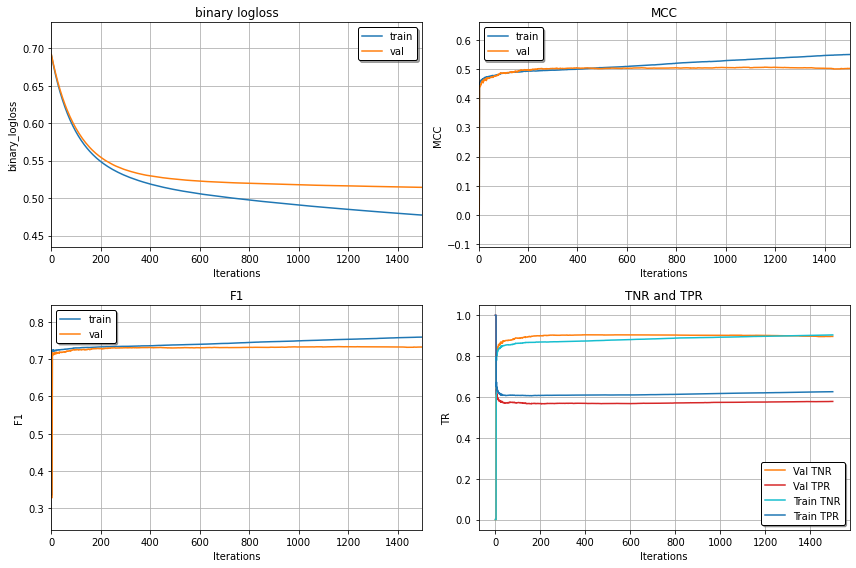

Duration: 0:35:04.626525

> Starting CV iteration 5, valid chrs = ['chr8' 'chr18' 'chr19']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.626687	train's MCC: 0.481535	train's F1: 0.727621	train's TNR: 0.862326	train's TPR: 0.603209	val's binary_logloss: 0.629468	val's MCC: 0.445433	val's F1: 0.715427	val's TNR: 0.815661	val's TPR: 0.621714
[100]	train's binary_logloss: 0.587896	train's MCC: 0.494464	train's F1: 0.732568	train's TNR: 0.874304	train's TPR: 0.601964	val's binary_logloss: 0.592974	val's MCC: 0.458824	val's F1: 0.721001	val's TNR: 0.828458	val's TPR: 0.620818
[150]	train's binary_logloss: 0.563572	train's MCC: 0.498239	train's F1: 0.734233	train's TNR: 0.876854	train's TPR: 0.602817	val's binary_logloss: 0.570759	val's MCC: 0.464822	val's F1: 0.724086	val's TNR: 0.830743	val's TPR: 0.624552
[200]	train's binary_logloss: 0.547618	train's MCC: 0.501065	train's F1: 0.735493	train's TNR: 0.878702	train's TPR: 0.603532	val's binary_logloss: 0.556961	val's MCC: 0.469602	val's F1: 0.726217	val's TNR: 0.8344	val's TPR: 0.625299
[250]	train's binary_logloss: 0.536566	train's MCC: 0.50213

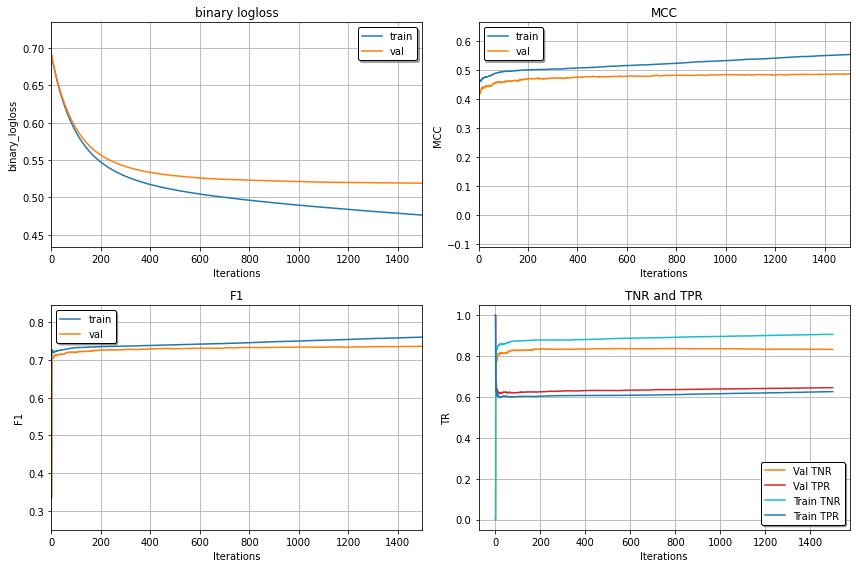

Duration: 0:35:10.685097

> Starting CV iteration 6, valid chrs = ['chrX' 'chr6' 'chr17']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.626998	train's MCC: 0.47728	train's F1: 0.725033	train's TNR: 0.863076	train's TPR: 0.597228	val's binary_logloss: 0.628791	val's MCC: 0.4613	val's F1: 0.718305	val's TNR: 0.845488	val's TPR: 0.6038
[100]	train's binary_logloss: 0.588528	train's MCC: 0.486996	train's F1: 0.728314	train's TNR: 0.873678	train's TPR: 0.594119	val's binary_logloss: 0.591392	val's MCC: 0.480095	val's F1: 0.726497	val's TNR: 0.859456	val's TPR: 0.606947
[150]	train's binary_logloss: 0.564457	train's MCC: 0.49231	train's F1: 0.73097	train's TNR: 0.876031	train's TPR: 0.596939	val's binary_logloss: 0.568411	val's MCC: 0.484051	val's F1: 0.728438	val's TNR: 0.861434	val's TPR: 0.608812
[200]	train's binary_logloss: 0.548592	train's MCC: 0.494195	train's F1: 0.732154	train's TNR: 0.875934	train's TPR: 0.599181	val's binary_logloss: 0.553742	val's MCC: 0.486056	val's F1: 0.729571	val's TNR: 0.861805	val's TPR: 0.610561
[250]	train's binary_logloss: 0.537554	train's MCC: 0.496155	tra

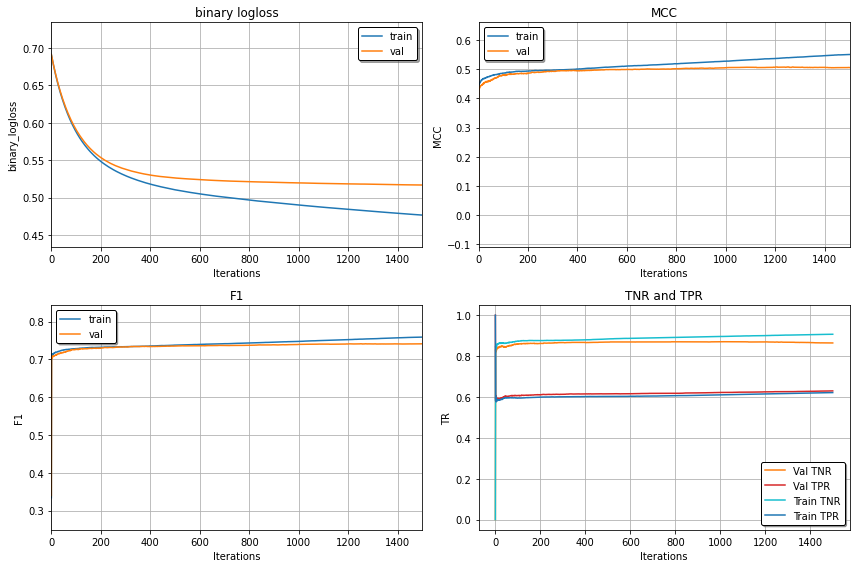

Duration: 0:34:35.596680

> Starting CV iteration 7, valid chrs = ['chr16' 'chr14' 'chr9']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.62708	train's MCC: 0.480762	train's F1: 0.727799	train's TNR: 0.859108	train's TPR: 0.60667	val's binary_logloss: 0.629116	val's MCC: 0.458885	val's F1: 0.720441	val's TNR: 0.834943	val's TPR: 0.612156
[100]	train's binary_logloss: 0.588496	train's MCC: 0.491971	train's F1: 0.731603	train's TNR: 0.871664	train's TPR: 0.602851	val's binary_logloss: 0.5921	val's MCC: 0.467075	val's F1: 0.722931	val's TNR: 0.846764	val's TPR: 0.606326
[150]	train's binary_logloss: 0.564278	train's MCC: 0.495822	train's F1: 0.733213	train's TNR: 0.874637	train's TPR: 0.603245	val's binary_logloss: 0.569256	val's MCC: 0.470534	val's F1: 0.724381	val's TNR: 0.849647	val's TPR: 0.606471
[200]	train's binary_logloss: 0.548352	train's MCC: 0.498894	train's F1: 0.734671	train's TNR: 0.876313	train's TPR: 0.604471	val's binary_logloss: 0.554768	val's MCC: 0.471205	val's F1: 0.724535	val's TNR: 0.8508	val's TPR: 0.605743
[250]	train's binary_logloss: 0.537267	train's MCC: 0.4998	trai

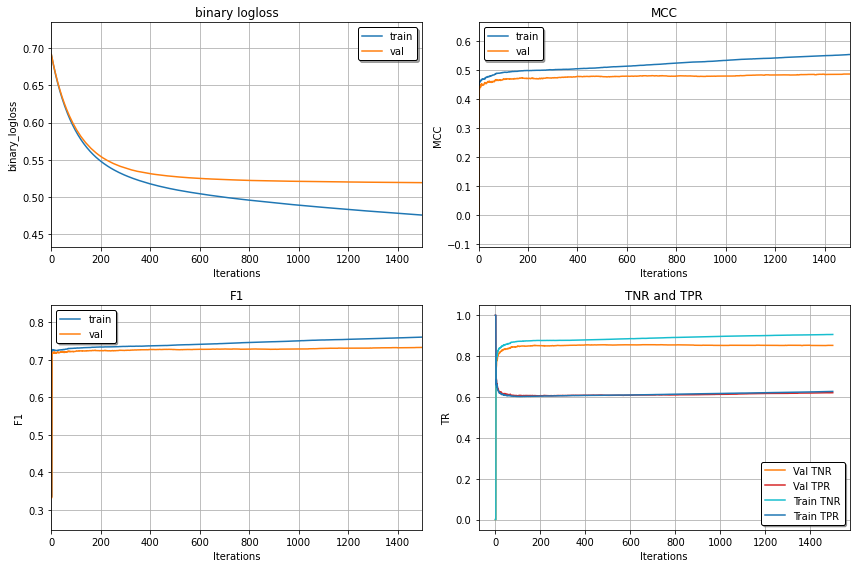

Duration: 0:34:39.060320

>> LGBM final report
Train CV accuracy: 0.7645
Train CV F1-score: 0.7281
Train MCC: 0.5526
Valid CV accuracy: 0.7357
Valid CV F1-score: 0.6997
Valid CV MCC: 0.4884
Valid TNR = 86.22%
Valid TPR = 61.11%
Duration: 4:03:23.266235


In [32]:
# LGBM without balancing the weights
params = {"application" : "binary",
          "metric" :"binary_logloss",
          "force_row_wise" : True,
          "learning_rate" : learning_rate            
}
lgb1_train_output, lgb1_val_output, _ = lgb_cv(X_TRAIN, y_TRAIN, metadata_train, params, cv_seed=33)

Performing LGBM CV

Parameters:
  num_iterations = 1500
  early_stopping_rounds = None
  application = binary
  metric = binary_logloss
  force_row_wise = True
  learning_rate = 0.009
  scale_pos_weight = 1.7

> Starting CV iteration 1, valid chrs = ['chr13' 'chr12' 'chr10']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.638025	train's MCC: 0.447472	train's F1: 0.719371	train's TNR: 0.641294	train's TPR: 0.800243	val's binary_logloss: 0.639725	val's MCC: 0.448863	val's F1: 0.721598	val's TNR: 0.658916	val's TPR: 0.78618
[100]	train's binary_logloss: 0.606506	train's MCC: 0.450861	train's F1: 0.721296	train's TNR: 0.645278	train's TPR: 0.799916	val's binary_logloss: 0.608288	val's MCC: 0.45793	val's F1: 0.726407	val's TNR: 0.6669	val's TPR: 0.787568
[150]	train's binary_logloss: 0.586494	train's MCC: 0.461229	train's F1: 0.727471	train's TNR: 0.660881	train's TPR: 0.795903	val's binary_logloss: 0.58773	val's MCC: 0.466808	val's F1: 0.73185	val's TNR: 0.68511	val's TPR: 0.77952
[200]	train's binary_logloss: 0.572973	train's MCC: 0.466755	train's F1: 0.730932	train's TNR: 0.671884	train's TPR: 0.79133	val's binary_logloss: 0.573653	val's MCC: 0.470292	val's F1: 0.733953	val's TNR: 0.692814	val's TPR: 0.775774
[250]	train's binary_logloss: 0.563274	train's MCC: 0.471441	train

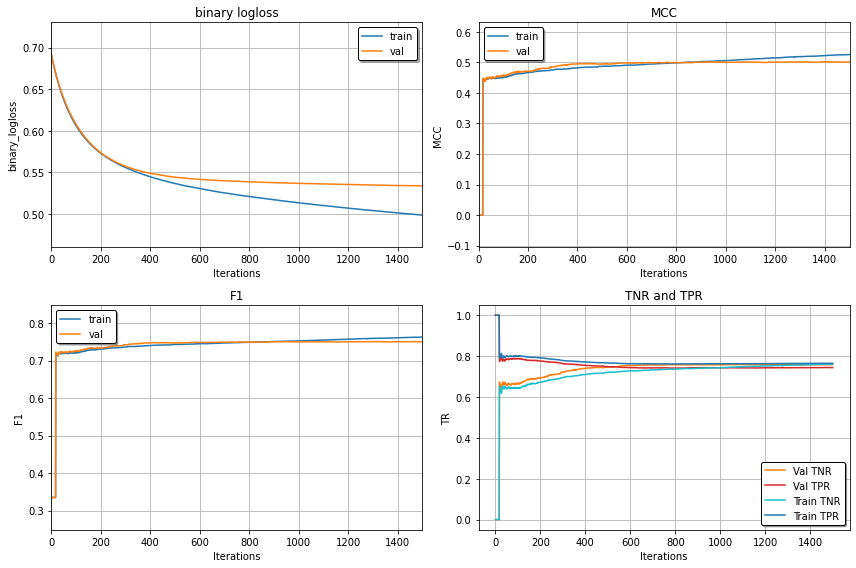

Duration: 0:34:46.770302

> Starting CV iteration 2, valid chrs = ['chr15' 'chr1' 'chr20']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.636666	train's MCC: 0.463989	train's F1: 0.730398	train's TNR: 0.684023	train's TPR: 0.777893	val's binary_logloss: 0.639302	val's MCC: 0.422785	val's F1: 0.710706	val's TNR: 0.669271	val's TPR: 0.751767
[100]	train's binary_logloss: 0.604197	train's MCC: 0.465224	train's F1: 0.730386	train's TNR: 0.675869	train's TPR: 0.786472	val's binary_logloss: 0.609026	val's MCC: 0.430766	val's F1: 0.714235	val's TNR: 0.664025	val's TPR: 0.764137
[150]	train's binary_logloss: 0.583536	train's MCC: 0.47061	train's F1: 0.733381	train's TNR: 0.682684	train's TPR: 0.785409	val's binary_logloss: 0.590356	val's MCC: 0.439641	val's F1: 0.718921	val's TNR: 0.673513	val's TPR: 0.763929
[200]	train's binary_logloss: 0.569572	train's MCC: 0.475396	train's F1: 0.736172	train's TNR: 0.690962	train's TPR: 0.782417	val's binary_logloss: 0.578426	val's MCC: 0.442023	val's F1: 0.720405	val's TNR: 0.681326	val's TPR: 0.759044
[250]	train's binary_logloss: 0.559637	train's MCC: 0.4799

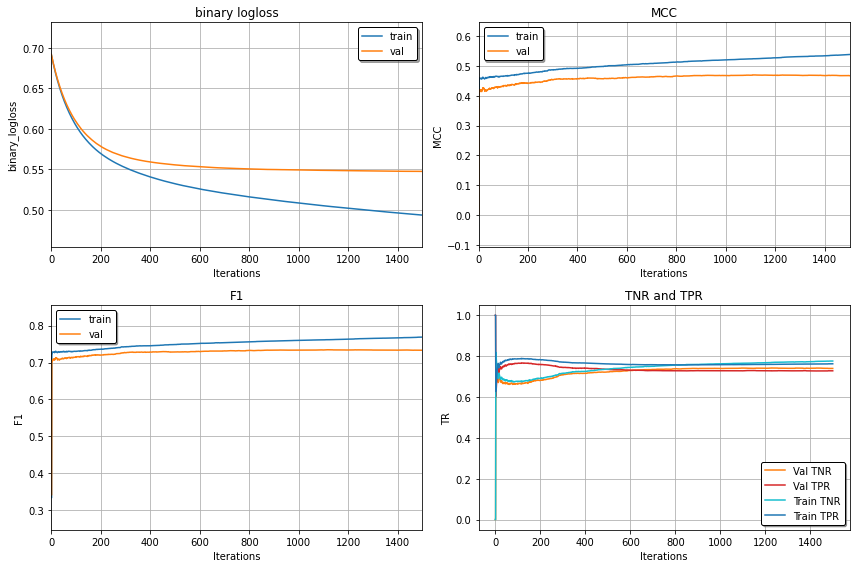

Duration: 0:34:26.014565

> Starting CV iteration 3, valid chrs = ['chr11' 'chr22' 'chrY']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.637489	train's MCC: 0.453548	train's F1: 0.722726	train's TNR: 0.646686	train's TPR: 0.801097	val's binary_logloss: 0.645604	val's MCC: 0.391529	val's F1: 0.686518	val's TNR: 0.584769	val's TPR: 0.798614
[100]	train's binary_logloss: 0.6054	train's MCC: 0.456982	train's F1: 0.724182	train's TNR: 0.645991	train's TPR: 0.804847	val's binary_logloss: 0.619976	val's MCC: 0.394039	val's F1: 0.687376	val's TNR: 0.583493	val's TPR: 0.801967
[150]	train's binary_logloss: 0.584888	train's MCC: 0.466164	train's F1: 0.729871	train's TNR: 0.661907	train's TPR: 0.799517	val's binary_logloss: 0.605111	val's MCC: 0.401534	val's F1: 0.692786	val's TNR: 0.598596	val's TPR: 0.795932
[200]	train's binary_logloss: 0.571036	train's MCC: 0.472818	train's F1: 0.734226	train's TNR: 0.677576	train's TPR: 0.791885	val's binary_logloss: 0.596415	val's MCC: 0.407149	val's F1: 0.697287	val's TNR: 0.614125	val's TPR: 0.787662
[250]	train's binary_logloss: 0.561138	train's MCC: 0.47941

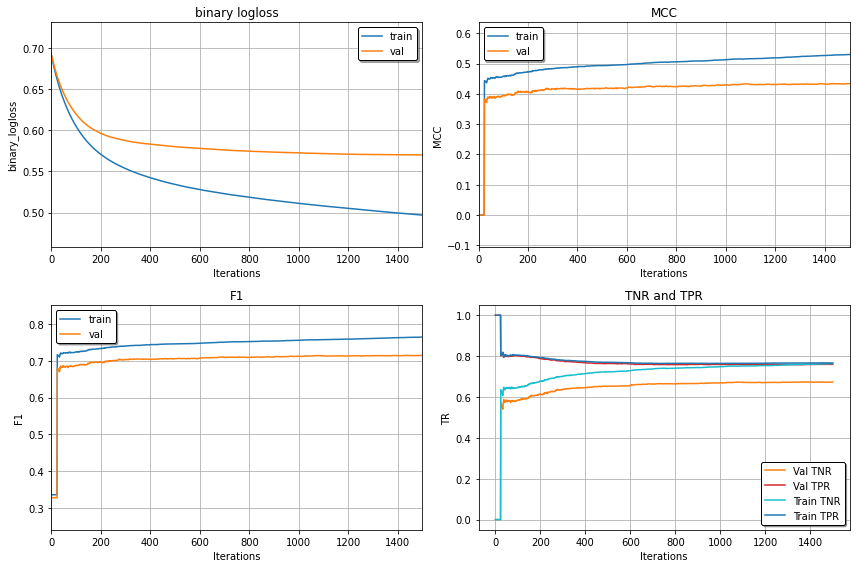

Duration: 0:35:23.174284

> Starting CV iteration 4, valid chrs = ['chr21' 'chr5' 'chr7']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.637909	train's MCC: 0.44683	train's F1: 0.719229	train's TNR: 0.641425	train's TPR: 0.799434	val's binary_logloss: 0.642793	val's MCC: 0.451251	val's F1: 0.722729	val's TNR: 0.667197	val's TPR: 0.781665
[100]	train's binary_logloss: 0.606274	train's MCC: 0.450873	train's F1: 0.721068	train's TNR: 0.641826	train's TPR: 0.802795	val's binary_logloss: 0.612505	val's MCC: 0.45743	val's F1: 0.725744	val's TNR: 0.669509	val's TPR: 0.785434
[150]	train's binary_logloss: 0.586221	train's MCC: 0.456713	train's F1: 0.724882	train's TNR: 0.653763	train's TPR: 0.797845	val's binary_logloss: 0.592699	val's MCC: 0.463713	val's F1: 0.729712	val's TNR: 0.682659	val's TPR: 0.779403
[200]	train's binary_logloss: 0.572684	train's MCC: 0.463661	train's F1: 0.729259	train's TNR: 0.66754	train's TPR: 0.792205	val's binary_logloss: 0.579042	val's MCC: 0.472019	val's F1: 0.734589	val's TNR: 0.697254	val's TPR: 0.773824
[250]	train's binary_logloss: 0.563035	train's MCC: 0.46911	

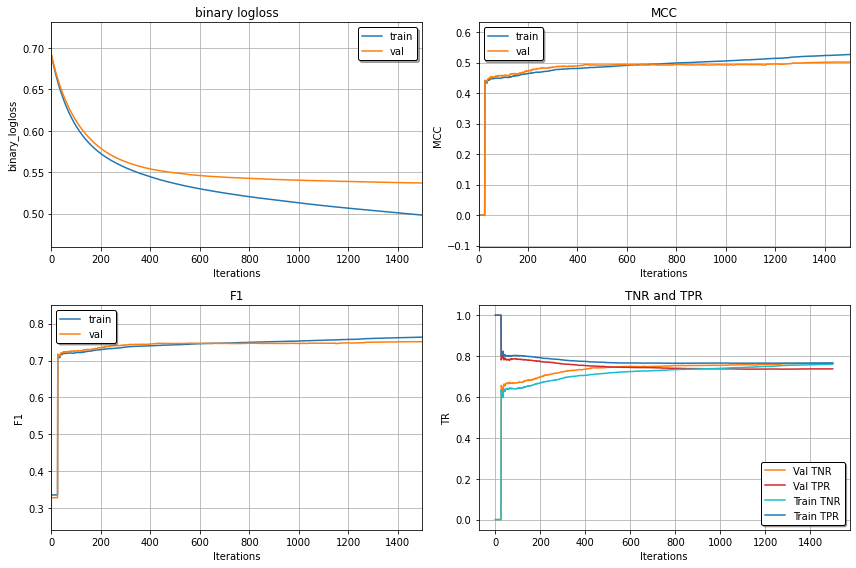

Duration: 0:34:58.419460

> Starting CV iteration 5, valid chrs = ['chr8' 'chr18' 'chr19']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.637569	train's MCC: 0.454153	train's F1: 0.723989	train's TNR: 0.65805	train's TPR: 0.791829	val's binary_logloss: 0.640375	val's MCC: 0.4218	val's F1: 0.703938	val's TNR: 0.605424	val's TPR: 0.807348
[100]	train's binary_logloss: 0.605591	train's MCC: 0.458092	train's F1: 0.725731	train's TNR: 0.657629	train's TPR: 0.795864	val's binary_logloss: 0.611585	val's MCC: 0.429349	val's F1: 0.707542	val's TNR: 0.608166	val's TPR: 0.811828
[150]	train's binary_logloss: 0.585192	train's MCC: 0.463554	train's F1: 0.728867	train's TNR: 0.664951	train's TPR: 0.794503	val's binary_logloss: 0.594288	val's MCC: 0.435653	val's F1: 0.711217	val's TNR: 0.615478	val's TPR: 0.81138
[200]	train's binary_logloss: 0.571468	train's MCC: 0.471925	train's F1: 0.733951	train's TNR: 0.680438	train's TPR: 0.788555	val's binary_logloss: 0.583784	val's MCC: 0.44166	val's F1: 0.715393	val's TNR: 0.628123	val's TPR: 0.806153
[250]	train's binary_logloss: 0.561622	train's MCC: 0.476802	t

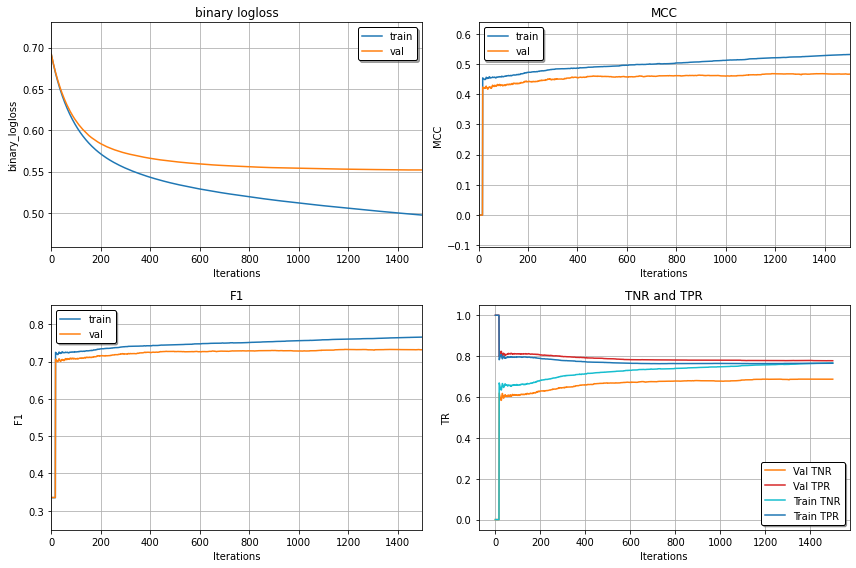

Duration: 0:35:19.889895

> Starting CV iteration 6, valid chrs = ['chrX' 'chr6' 'chr17']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.63778	train's MCC: 0.454008	train's F1: 0.725625	train's TNR: 0.681708	train's TPR: 0.770451	val's binary_logloss: 0.637582	val's MCC: 0.443312	val's F1: 0.719943	val's TNR: 0.663288	val's TPR: 0.776664
[100]	train's binary_logloss: 0.606092	train's MCC: 0.457199	train's F1: 0.726203	train's TNR: 0.668947	train's TPR: 0.785081	val's binary_logloss: 0.606339	val's MCC: 0.450163	val's F1: 0.722406	val's TNR: 0.654141	val's TPR: 0.791118
[150]	train's binary_logloss: 0.585963	train's MCC: 0.463473	train's F1: 0.729654	train's TNR: 0.676249	train's TPR: 0.78443	val's binary_logloss: 0.587032	val's MCC: 0.454536	val's F1: 0.724856	val's TNR: 0.659703	val's TPR: 0.790302
[200]	train's binary_logloss: 0.572378	train's MCC: 0.467828	train's F1: 0.73226	train's TNR: 0.684546	train's TPR: 0.781032	val's binary_logloss: 0.57445	val's MCC: 0.461478	val's F1: 0.728698	val's TNR: 0.668232	val's TPR: 0.789253
[250]	train's binary_logloss: 0.562624	train's MCC: 0.472607	

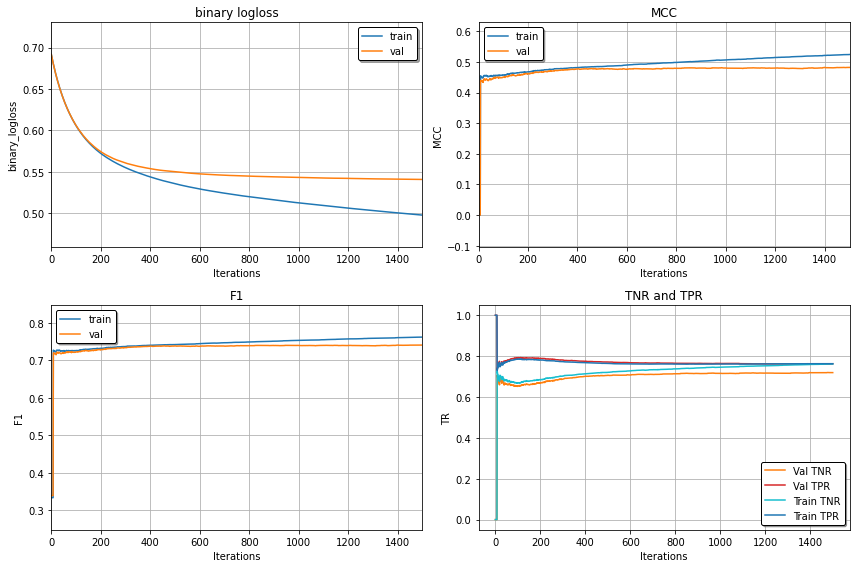

Duration: 0:34:48.413254

> Starting CV iteration 7, valid chrs = ['chr16' 'chr14' 'chr9']


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


[50]	train's binary_logloss: 0.637909	train's MCC: 0.451645	train's F1: 0.721359	train's TNR: 0.642083	train's TPR: 0.803347	val's binary_logloss: 0.641053	val's MCC: 0.419495	val's F1: 0.70262	val's TNR: 0.6079	val's TPR: 0.803673
[100]	train's binary_logloss: 0.606107	train's MCC: 0.459479	train's F1: 0.726092	train's TNR: 0.654143	train's TPR: 0.80013	val's binary_logloss: 0.611662	val's MCC: 0.428139	val's F1: 0.707779	val's TNR: 0.618855	val's TPR: 0.802215
[150]	train's binary_logloss: 0.58587	train's MCC: 0.465591	train's F1: 0.729909	train's TNR: 0.665565	train's TPR: 0.795802	val's binary_logloss: 0.593533	val's MCC: 0.440214	val's F1: 0.715038	val's TNR: 0.635289	val's TPR: 0.799155
[200]	train's binary_logloss: 0.572198	train's MCC: 0.469322	train's F1: 0.732433	train's TNR: 0.675501	train's TPR: 0.790479	val's binary_logloss: 0.581939	val's MCC: 0.443465	val's F1: 0.717774	val's TNR: 0.647254	val's TPR: 0.791721
[250]	train's binary_logloss: 0.562402	train's MCC: 0.476363	t

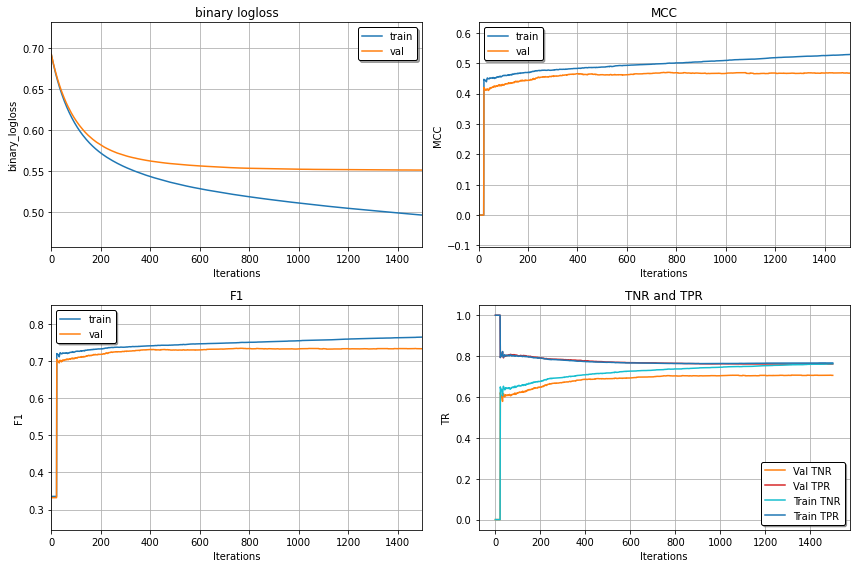

Duration: 0:35:24.437897

>> LGBM final report
Train CV accuracy: 0.7646
Train CV F1-score: 0.7661
Train MCC: 0.5293
Valid CV accuracy: 0.7379
Valid CV F1-score: 0.7429
Valid CV MCC: 0.4759
Valid TNR = 72.43%
Valid TPR = 75.13%
Duration: 4:05:21.901628


In [33]:
# LGBM with balancing the weights
params = {"application" : "binary",
          "metric" : "binary_logloss",
          "force_row_wise" : True,
          "learning_rate" : learning_rate,
          "scale_pos_weight": 1.7         
}
lgb2_train_output, lgb2_val_output, _ = lgb_cv(X_TRAIN, y_TRAIN, metadata_train, params, cv_seed=33)

## SVM

SVM SVC model

In [ ]:
# # Train and predict SVM SVC
# def svc_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM SVC"):
#   start_time = datetime.now()
#   # Train and predict
#   model = model.fit(xtrain, ytrain)
#   ytrain_prob = model.predict_proba(xtrain)[:,1]
#   ytest_prob = model.predict_proba(xtest)[:,1]
#   ytrain_pred = model.predict(xtrain)
#   ytest_pred = model.predict(xtest)
#   # Evaluate
#   print(f"{name} train accuracy: {get_accuracy(ytrain_pred, ytrain):.4}")
#   print(f"{name} test accuracy: {get_accuracy(ytest_pred, ytest):.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return model, ytrain_prob, ytrain_pred, ytest_prob, ytest_pred

# svc_rbf = svm.SVC(kernel='rbf', C=100, gamma=0.1, probability=True)
# #svc_model, svc_train_yprob, svc_train_ypred, svc_val_yprob, svc_val_ypred = svc_train_pred(X_train, y_train, X_val, y_val, model=svc_rbf)

SVM SVR with Logistic Regression on top of the SVM scores

In [35]:
# # Train and predict 
# def svrlr_train_pred(xtrain, ytrain, xtest, ytest, model, name="SVM SVR"):
#   start_time = datetime.now()
#   # Train and predict svm score
#   svm_model = model.fit(xtrain, ytrain)
#   svm_train_yscore = svm_model.predict(xtrain).reshape(-1,1)
#   svm_test_yscore = svm_model.predict(xtest).reshape(-1,1)
#   # Train a logistic regression on top of svm output
#   lreg_model = LogisticRegression(solver='lbfgs', 
#                                   random_state=0, 
#                                   max_iter = 2000).fit(svm_train_yscore, 
#                                                        ytrain)
#   train_yprob = lreg_model.predict_proba(svm_train_yscore)[:,1]
#   train_ypred = lreg_model.predict(svm_train_yscore)
#   test_yprob = lreg_model.predict_proba(svm_test_yscore)[:,1]
#   test_ypred = lreg_model.predict(svm_test_yscore)
#   # Evaluate
#   print(f"{name} train accuracy: {get_accuracy(train_ypred, ytrain):.4}")
#   print(f"{name} test accuracy: {get_accuracy(test_ypred, ytest):.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return svm_model, lreg_model, train_yprob, train_ypred, test_yprob, test_ypred

# svr_rbf = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
# #_, _, svm_train_yprob, svm_train_ypred, svm_val_yprob, svm_val_ypred = svrlr_train_pred(X_train, y_train, X_val, y_val, model=svr_rbf)

SVM CV both SVC and SVR + LG

In [36]:
# # SVM CV
# def svm_cv(xtrain, ytrain, model=svc_rbf, svm_algo="SVC", kfold=10, name="SVM"):
#   start_time = datetime.now()
#   print(f"Performing {name} {svm_algo} CV")
#   # Initialize 1d df to store predictions and true values
#   train_yprob_vec, train_ypred_vec, train_ytrue_vec = np.array([]), np.array([]), np.array([])
#   val_yprob_vec, val_ypred_vec, val_ytrue_vec = np.array([]), np.array([]), np.array([])
#   # Stratified CV
#   skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=26)
#   for i, (itrain, ival) in enumerate(skf.split(xtrain, ytrain)):
#     print(f"\n> Starting CV iteration {i+1}")
#     # Split data according to folds
#     X_train, X_val = xtrain.iloc[itrain], xtrain.iloc[ival]
#     y_train, y_val = ytrain[itrain], ytrain[ival]
#     # Normalization
#     scaler = StandardScaler()
#     X_train = scaler.fit_transform(X_train)
#     X_val = scaler.transform(X_val)
#     # Train and predict
#     if svm_algo=="SVC":
#       _, train_yprob, train_ypred, val_yprob, val_ypred = svc_train_pred(X_train, y_train, X_val, y_val, model=model)
#     elif svm_algo=="SVR":
#       _, _, train_yprob, train_ypred, val_yprob, val_ypred = svrlr_train_pred(X_train, y_train, X_val, y_val, model=model)
#     else:
#       print("svm_algo argument must specify \"SVC\" or \"SVR\"")
#     # Store prediction on training data
#     train_yprob_vec = np.concatenate((train_yprob_vec, train_yprob))
#     train_ypred_vec = np.concatenate((train_ypred_vec, train_ypred))
#     train_ytrue_vec = np.concatenate((train_ytrue_vec, y_train))
#     # Store prediction on validation data
#     val_yprob_vec = np.concatenate((val_yprob_vec, val_yprob))
#     val_ypred_vec = np.concatenate((val_ypred_vec, val_ypred))
#     val_ytrue_vec = np.concatenate((val_ytrue_vec, y_val))
#   # Stack training and validation predictions into two panda df
#   train_output = pd.DataFrame({"yprob": train_yprob_vec, "ypred": train_ypred_vec,"ytrue": train_ytrue_vec})
#   val_output = pd.DataFrame({"yprob": val_yprob_vec, "ypred": val_ypred_vec,"ytrue": val_ytrue_vec})
#   # Evaluate
#   train_acc = get_accuracy(train_output["ypred"].values, train_output["ytrue"].values)
#   val_acc = get_accuracy(val_output["ypred"].values, val_output["ytrue"].values)
#   train_rmse = get_rmse(train_output["yprob"].values, train_output["ytrue"].values)
#   val_rmse = get_rmse(val_output["yprob"].values, val_output["ytrue"].values)
#   print(f"\n>> {name} final report")
#   print(f"Train CV accuracy: {train_acc:.4}")
#   print(f"Valid CV accuracy: {val_acc:.4}")
#   # Report time 
#   print(f"Duration: {datetime.now() - start_time}")
#   return train_output, val_output

# # # SVC CV
# # svc_train_output, svc_val_output = svm_cv(X_TRAIN, y_TRAIN, 
# #                                           svm_algo="SVC", kfold=2, model=svc_rbf)

In [37]:
# # SVR CV
# svr_train_output, svr_val_output = svm_cv(X_TRAIN, y_TRAIN, 
#                                           svm_algo="SVR", kfold=2, model=svr_rbf)

## Features importance

In [38]:
# # Feature importance
# plt.figure(figsize=(12, 8))
# gs = gridspec.GridSpec(1, 2)

# ax = plt.subplot(gs[0, 0])
# sns.barplot(x='average', y='feature', data=rf_importance.sort_values('average', ascending=False).iloc[0:20], ax=ax)
# plt.title("Random forest feature importance", fontsize=15)

# ax = plt.subplot(gs[0, 1])
# sns.barplot(x='average', y='feature', data=lgb_importance.sort_values('average', ascending=False).iloc[0:20], ax=ax)
# plt.title("LightGBM feature importance gain", fontsize=15)

# # ax = plt.subplot(gs[0, 2])
# # sns.barplot(x='lgb_importance_split', y='feature', data=imp_df.sort_values('lgb_importance_split', ascending=False).iloc[0:20], ax=ax)
# # ax.set_title('LightGBM feature importance split', fontsize=15)
# plt.tight_layout()
# plt.savefig(f"{DIRECTORY}feature_importance_{FILENAME}.png", dpi = 300)
# plt.show()

# # Export files
# rf_importance.to_csv(f"{DIRECTORY}rf_importance_{FILENAME}.csv", index=False)
# lgb_importance.to_csv(f"{DIRECTORY}lgb_importance_{FILENAME}.csv", index=False)

In [39]:
# # LGBM Feature importance
# plt.rcParams['figure.figsize'] = (18.0, 4)
# fig, ax = plt.subplots(figsize=(12,8))
# lgb.plot_importance(lgb_model, max_num_features=20, height=0.8, ax=ax)
# ax.grid(False)
# plt.title("LightGBM feature importance ", fontsize=15)

## Performance evaluation

In [42]:
# Initialize the models to evaluate
train_output_lst = rf1_train_output, lgb1_train_output, lgb2_train_output    
val_output_lst = rf1_val_output, lgb1_val_output, lgb2_val_output 
names = "RF", "LGBM", "LGBM pos X1.7"             

#### Classification report

In [43]:
# Classification report
for i in range(len(names)):
  print(f"{names[i]}:\n", classification_report(val_output_lst[i]["ytrue"], val_output_lst[i]["ypred"])) 

RF:
               precision    recall  f1-score   support

         0.0       0.72      0.74      0.73     49310
         1.0       0.74      0.72      0.73     50069

    accuracy                           0.73     99379
   macro avg       0.73      0.73      0.73     99379
weighted avg       0.73      0.73      0.73     99379

LGBM:
               precision    recall  f1-score   support

         0.0       0.69      0.86      0.76     49310
         1.0       0.82      0.61      0.70     50069

    accuracy                           0.74     99379
   macro avg       0.75      0.74      0.73     99379
weighted avg       0.75      0.74      0.73     99379

LGBM pos X1.7:
               precision    recall  f1-score   support

         0.0       0.74      0.72      0.73     49310
         1.0       0.73      0.75      0.74     50069

    accuracy                           0.74     99379
   macro avg       0.74      0.74      0.74     99379
weighted avg       0.74      0.74      0.74   

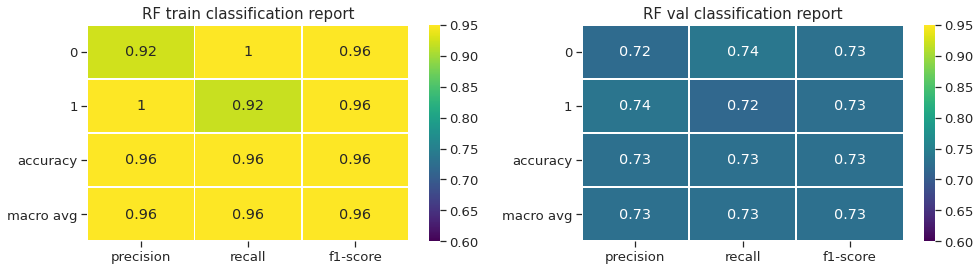

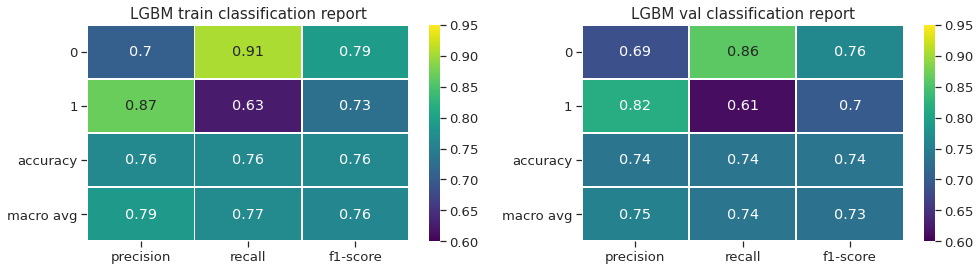

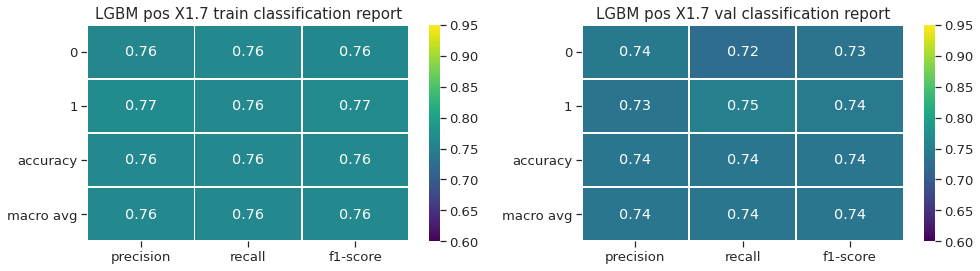

In [44]:
# Plot classification report
def plot_clf_report(train_output, val_output, name="", save=False):
  plt.figure(figsize=(14, 4))
  gs = gridspec.GridSpec(1, 2)
  sns.set(font_scale=1.2, style="ticks")
  # Train
  ax = plt.subplot(gs[0, 0])
  clf_report = classification_report(train_output["ytrue"], train_output["ypred"],
                                    labels=[0,1], output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].drop(["weighted avg"], axis=1).T, 
              annot=True, linewidths=1, cmap="viridis", ax=ax, vmin=0.6, vmax=0.95)
  ax.set_title(f"{name} train classification report", fontsize=15)
  # Validation
  ax = plt.subplot(gs[0, 1])
  clf_report = classification_report(val_output["ytrue"], val_output["ypred"],
                                    labels=[0,1], output_dict=True)
  sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].drop(["weighted avg"], axis=1).T, 
              annot=True, linewidths=1, cmap="viridis", ax=ax, vmin=0.6, vmax=0.95)
  ax.set_title(f"{name} val classification report", fontsize=15)
  # Layout and save
  plt.tight_layout()
  if save:
    plt.savefig(f"{DIRECTORY}classification_report_{FILENAME}_{name}.png", dpi = 300)
  plt.show()

for i in range(len(names)):
  plot_clf_report(train_output_lst[i], val_output_lst[i], names[i], save=True)

#### Plot some metrics

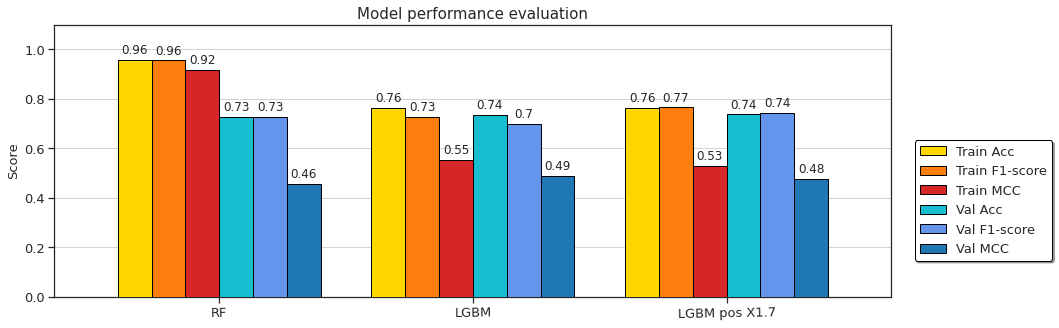

In [45]:
# Plot accuracy, F1, MCC

def evaluate(ml_output):
  acc = get_accuracy(ml_output["ypred"], ml_output["ytrue"])
  f1 = f1_score(ml_output["ytrue"], ml_output["ypred"])
  mcc = matthews_corrcoef(ml_output["ytrue"], ml_output["ypred"])
  return acc, f1, mcc

def evaluate_lst(ml_output_lst):
  lst_acc, lst_f1, lst_mcc = [], [], []
  for ml_output in ml_output_lst: 
    acc, f1, mcc = evaluate(ml_output)
    lst_acc.append(acc)
    lst_f1.append(f1)
    lst_mcc.append(mcc)
  return lst_acc, lst_f1, lst_mcc

def plot_metrics(train_output_lst, val_output_lst, names, 
                 bbox_to_anchor=(1.03, 0.6), annotation_size=13, 
                 save=False):
  # Group by metrics
  train_acc, train_f1, train_mcc = evaluate_lst(train_output_lst)
  val_acc, val_f1, val_mcc = evaluate_lst(val_output_lst)
  # Plot
  metric_df = pd.DataFrame({"Train Acc": train_acc, "Train F1-score": train_f1, "Train MCC": train_mcc,
                            "Val Acc": val_acc, "Val F1-score": val_f1, "Val MCC": val_mcc, }, 
                            index = names)
  ax = metric_df.plot(y=["Train Acc", "Train F1-score", "Train MCC", "Val Acc", "Val F1-score", "Val MCC"], 
                      ylim=(0,1.1), figsize=(15,5), fontsize=13, kind="bar", zorder=3, ec ="black",
                      rot=1, width=0.8, color = ["gold", "tab:orange", "tab:red",
                                                "tab:cyan", "cornflowerblue", "tab:blue"])
  # Add details
  plt.title("Model performance evaluation", fontsize = 15)
  plt.ylabel("Score", fontsize = 13)
  plt.grid(axis="y", zorder=0, color="lightgray")  
  legend = plt.legend(frameon = 1, shadow = True, bbox_to_anchor=bbox_to_anchor, fontsize=13)
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  # Annotate scores on top of the bars
  for p in ax.patches:
    height = p.get_height()
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    xpos='center'
    offset = {'center': 0, 'right': 1, 'left': -1}
    ax.annotate(f"{height:.2}",
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(offset[xpos]*3, 3),  
                textcoords="offset points",  
                ha=ha[xpos], va='bottom', size=annotation_size)
  if save:
    plt.savefig(f"{DIRECTORY}models_performance_{FILENAME}.png", 
                dpi = 300, bbox_extra_artists=(legend,), bbox_inches='tight')
  plt.show()

plot_metrics(train_output_lst, val_output_lst, names, 
             bbox_to_anchor=(1.2, 0.6), annotation_size=12, save=True)                        # annotation_size= 13 for 2, 12 for 3, 11 for 4

#### ROC

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


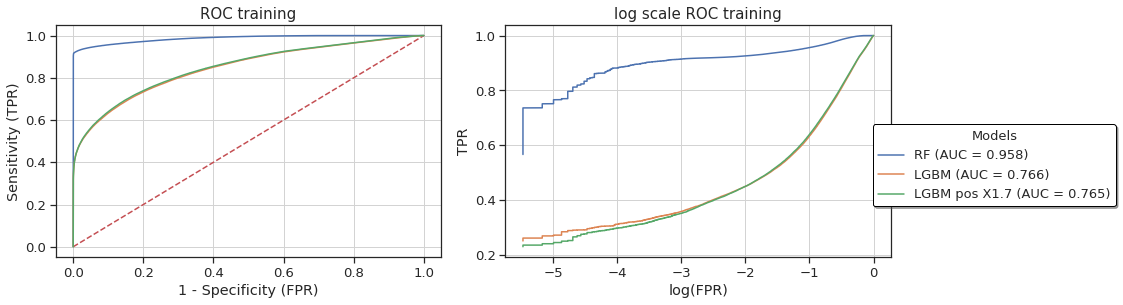

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10


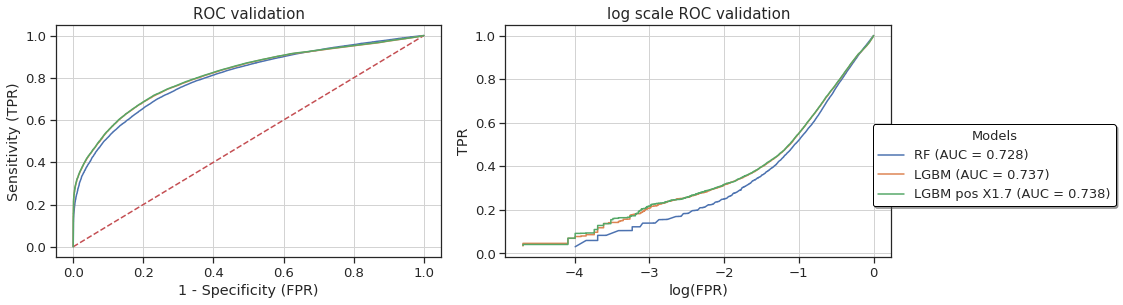

In [46]:
# Compute AUC, FPR and TPR
def get_auc_fpr_tpr(ml_output):
  auc = roc_auc_score(ml_output["ytrue"], ml_output["ypred"])
  fpr, tpr, _ = roc_curve(ml_output["ytrue"], ml_output["yprob"])
  return auc, fpr, tpr

# Plot ROC
def plot_ROC(output_lst, names, plot_name="", save=False):
  fig, axes = plt.subplots(1, 2, figsize = (16, 4.5))
  # ROC
  for i, output in enumerate(output_lst):
    auc, fpr, tpr = get_auc_fpr_tpr(output)
    axes[0].plot(fpr, tpr, label=f"{names[i]} (AUC = {auc:.3})", zorder=3)
  axes[0].plot([0, 1], [0, 1],'r--')
  axes[0].set_title(f"ROC {plot_name}", fontsize=15)
  axes[0].set_xlabel('1 - Specificity (FPR)')
  axes[0].set_ylabel('Sensitivity (TPR)')
  axes[0].grid(zorder=0, color="lightgray")
  # Log ROC
  for i, output in enumerate(output_lst):
    auc, fpr, tpr = get_auc_fpr_tpr(output)
    axes[1].plot(np.log10(fpr), tpr, label=f"{names[i]} (AUC = {auc:.3})", zorder=3)
  axes[1].set_title(f"log scale ROC {plot_name}", fontsize=15)
  axes[1].set_xlabel('log(FPR)')
  axes[1].set_ylabel('TPR')
  axes[1].grid(zorder=0, color="lightgray")
  # Details
  legend = plt.legend(title="Models", fontsize=13, title_fontsize=13,
                      frameon = 1, shadow = True, bbox_to_anchor=(1.6, 0.6))
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  fig.tight_layout()
  fig.subplots_adjust(top=0.89)
  if save:
    plt.savefig(f"{DIRECTORY}ROC_logROC_{plot_name}_{FILENAME}.png", dpi = 300)
  plt.show()

plot_ROC(train_output_lst, names, plot_name="training", save=True)
plot_ROC(val_output_lst, names, plot_name="validation", save=True)

#### Precision recall curve

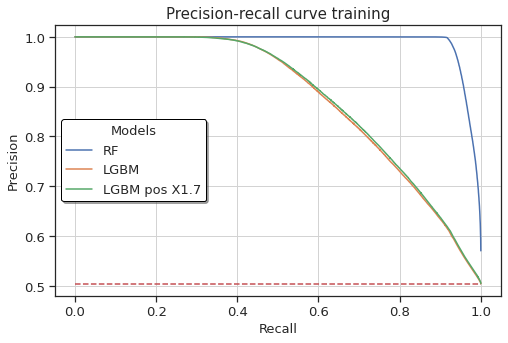

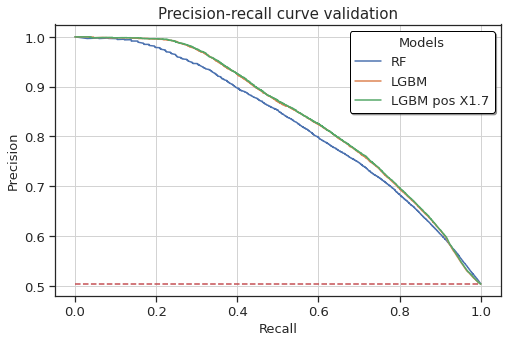

In [47]:
# Precision-recall curve
def plot_precision_recall_curve(output_lst, names, plot_name="", save=False):
  # Plot the curves
  plt.figure(figsize=(8, 5))
  random_clf = len(output_lst[0]["ytrue"][output_lst[0]["ytrue"]==1]) / len(output_lst[0]["ytrue"])
  plt.plot([0, 1], [random_clf, random_clf], 'r--', zorder=3)
  for i, val_output in enumerate(output_lst):
    precision, recall, thresholds = precision_recall_curve(val_output["ytrue"], val_output["yprob"])
    plt.plot(recall, precision, label=names[i], zorder=3)
  # Add details
  plt.grid(zorder=0, color="lightgray")
  plt.xlabel("Recall", fontsize=13)
  plt.ylabel("Precision", fontsize=13)
  plt.title(f"Precision-recall curve {plot_name}", fontsize=15)
  legend = plt.legend(title="Models", fontsize=13, title_fontsize=13,
            frameon = 1, shadow = True)
  frame = legend.get_frame()
  frame.set_facecolor("white")
  frame.set_edgecolor("black")
  if save:
    plt.savefig(f"{DIRECTORY}precision-recall_curve_{plot_name}_{FILENAME}.png", dpi = 300)
  plt.show()

plot_precision_recall_curve(train_output_lst, names, plot_name="training", save=True)
plot_precision_recall_curve(val_output_lst, names, plot_name="validation", save=True)

#### Confusion matrix

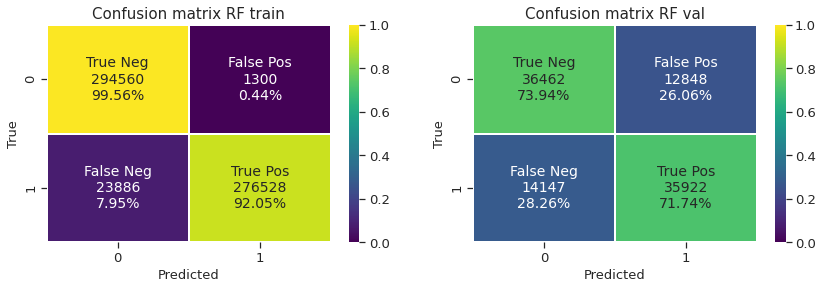

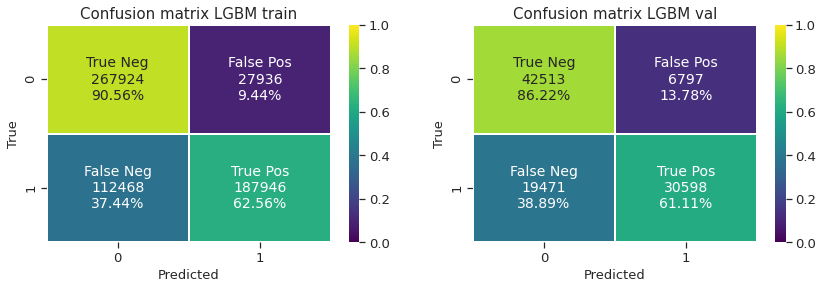

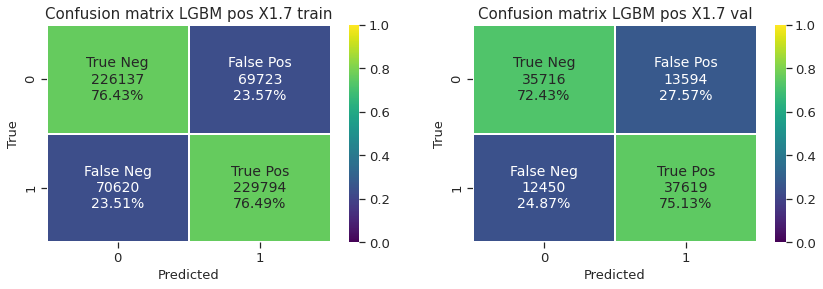

In [48]:
# Plot confusion matrix
def plot_confusion_matrix(train_output, val_output, name="",
                          vmax=0.6, save=False, filename="", cmap='viridis'):
  # Initialize
  val_train_output = train_output, val_output
  plot_names = "train", "val"
  plt.figure(figsize=(14, 4))
  gs = gridspec.GridSpec(1, 2)
  sns.set(font_scale=1.2, style="ticks")
  # Plot train and validation 
  for i, output in enumerate(val_train_output):
    ax = plt.subplot(gs[0, i])
    # Get confusion matrix and labels
    cf_matrix = confusion_matrix(output["ytrue"], output["ypred"])
    group_names = ["True Neg","False Pos","False Neg","True Pos"]
    group_counts = [f"{value}" for value in cf_matrix.flatten()]
    row_sums = cf_matrix.sum(axis=1)
    norm_matrix = cf_matrix / row_sums[:, np.newaxis]
    group_percentages = [f"{value*100:.2f}%" for value in norm_matrix.flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    # Plot heatmap
    sns.heatmap(norm_matrix, annot=labels, annot_kws={"size": 14}, 
                fmt="", vmin=0, vmax=1, cmap=cmap, linewidths=1, ax=ax)
    plt.ylabel("True", fontsize = 13)
    plt.xlabel("Predicted", fontsize = 13)
    plt.title(f"Confusion matrix {name} {plot_names[i]}", fontsize = 15)
  if save:
    plt.savefig(f"{DIRECTORY}confusion_matrix_{name}_{FILENAME}.png", 
                dpi = 300)
  plt.show()

for i in range(len(names)):
  plot_confusion_matrix(train_output_lst[i], val_output_lst[i], names[i], save=True)

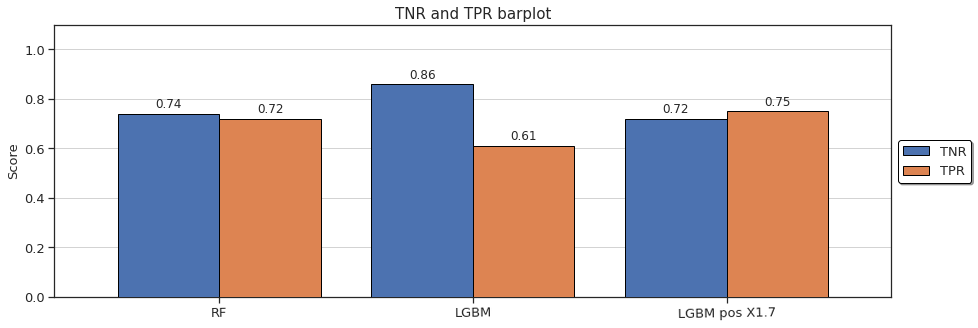

In [49]:
# Barplot of TNR and TPR
def get_tnr_tpr(ml_output):
  cf_matrix = confusion_matrix(ml_output["ytrue"], ml_output["ypred"])
  group_counts = [f"{value}" for value in cf_matrix.flatten()]
  row_sums = cf_matrix.sum(axis=1)
  norm_matrix = cf_matrix / row_sums[:, np.newaxis]
  group_percentages = [round(value, 2) for value in norm_matrix.flatten()]
  tnr, tpr = group_percentages[0], group_percentages[3]
  return tnr, tpr

def get_tnr_tpr_lst(ml_output_lst):
  lst_tnr, lst_tpr = [], []
  for ml_output in ml_output_lst: 
    tnr, tpr = get_tnr_tpr(ml_output)
    lst_tnr.append(tnr)
    lst_tpr.append(tpr)
  return lst_tnr, lst_tpr


def plot_tp_tn(val_output_lst, names, 
              bbox_to_anchor=(1.03, 0.6), annotation_size=13, 
                 save=False):
  # Group by metrics
  tnr, tpr = get_tnr_tpr_lst(val_output_lst)
  # Plot
  metric_df = pd.DataFrame({"TNR": tnr, "TPR": tpr}, index = names)
  ax = metric_df.plot(y=["TNR", "TPR"], 
                      ylim=(0,1.1), figsize=(15,5), fontsize=13, kind="bar", zorder=3, ec ="black",
                      rot=1, width=0.8)
  # Add details
  plt.title("TNR and TPR barplot", fontsize = 15)
  plt.ylabel("Score", fontsize = 13)
  plt.grid(axis="y", zorder=0, color="lightgray")  
  legend = plt.legend(frameon = 1, shadow = True, bbox_to_anchor=bbox_to_anchor, fontsize=13)
  frame = legend.get_frame()
  frame.set_facecolor('white')
  frame.set_edgecolor('black')
  # Annotate scores on top of the bars
  for p in ax.patches:
    height = p.get_height()
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    xpos='center'
    offset = {'center': 0, 'right': 1, 'left': -1}
    ax.annotate(f"{height:.2}",
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(offset[xpos]*3, 3),  
                textcoords="offset points",  
                ha=ha[xpos], va='bottom', size=annotation_size)
  if save:
    plt.savefig(f"{DIRECTORY}tnr_tpr_barplot_{FILENAME}.png", 
                dpi = 300, bbox_extra_artists=(legend,), bbox_inches='tight')
  plt.show()


plot_tp_tn(val_output_lst, names, bbox_to_anchor=(1, 0.6), annotation_size=12, save=True)    
  